## Setup

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/WignerMolecule.jl/analysis`


Status `~/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.8
⌃ [780c37f4] Carlo v0.2.6
  [074ae576] CarloAnalysis v1.0.0-DEV `https://github.com/PatXue/CarloAnalysis.jl#main`
  [a93c6f00] DataFrames v1.8.1
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.3
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.16
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [2]:
using CairoMakie
using Carlo.ResultTools
using CarloAnalysis
using DataFrames
using HDF5
using JLD2
using LinearAlgebra
using PeriodicArrays
using StaticArrays

In [3]:
function etak_tranform(etak_corrs)
    result = map(Iterators.product(1:3, 1:3)) do (x, y)
        etak_corrs[:, :, x, y]
    end
    return reshape(result, (9,))
end

Γ(corrs) = abs.(getindex.(corrs, 1, 1))
function M(corrs)
    Ms = Vector(undef, length(corrs))
    for i in eachindex(corrs)
        Lx, Ly = size(corrs[i])
        Ms[i] = abs(corrs[i][div(Lx, 2)+1, 1])
    end
    return Ms
end
function half_M(corrs)
    Ms = Vector(undef, length(corrs))
    for i in eachindex(corrs)
        Lx, Ly = size(corrs[i])
        Ms[i] = abs(corrs[i][div(Lx, 4)+1, 1])
    end
    return Ms
end

function separate_etaks!(data::AbstractDataFrame)
    col_names = [:ηk_xx, :ηk_yx, :ηk_zx, :ηk_xy, :ηk_yy, :ηk_zy, :ηk_xz, :ηk_yz, :ηk_zz]
    select!(
        data,
        Not(:etak_corrs),
        :etak_corrs => (corrs -> etak_tranform.(corrs)) => col_names,
    )
    transform!(
        data,
        col_names .=> Γ,
        col_names .=> M,
        col_names .=> half_M
    )
    return nothing
end

function separate_spinks!(data::AbstractDataFrame)
    transform!(
        data,
        :spink_corrs .=> Γ,
        :spink_corrs .=> M,
        :spink_corrs .=> half_M
    )
    return nothing
end

function clean_corrs!(data::AbstractDataFrame)
    separate_etaks!(data)
    separate_spinks!(data)
end

clean_corrs! (generic function with 1 method)

In [4]:
function gen_path(Lx, Ly)
    pos = (1, 1)
    path = [pos]
    while pos[1] < div(Lx, 2) + 1
        pos = pos .+ (1, 0)
        push!(path, pos)
    end
    M_pos = length(path)
    while pos[2] < div(Ly, 3, RoundNearest) + 1
        pos = pos .+ (1, 2)
        push!(path, pos)
    end
    K_pos = length(path)
    while pos[1] > 2
        pos = pos .- (2, 1)
        push!(path, pos)
    end
    return (path, M_pos, K_pos)
end

gen_path (generic function with 1 method)

In [5]:
function generate_spins(jobname, task_no)
    fig = Figure(size=(800, 400))

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
        spins = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/spins")
        )
        spin_xs = map(v -> v[1], spins)
        spin_ys = map(v -> v[2], spins)
        spin_zs = map(v -> v[3], spins)
        Lx, Ly = size(spins)
        fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
        strength = vec(spin_zs)
        arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))

        ηs = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/etas")
        )
        η_xs = getindex.(ηs, 1)
        η_ys = getindex.(ηs, 2)
        η_zs = getindex.(ηs, 3)
        Lx, Ly = size(ηs)
        fig[1,2] = Axis(fig; title="ηs", backgroundcolor="black")
        strength = vec(η_zs)
        arrows2d!(1:Lx, 1:Ly, η_xs, η_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))
    end

    return fig
end

generate_spins (generic function with 1 method)

## AFM-FE Phase Center

In [33]:
center_results = JobResult("../jobs", "afm-fe-center")

JobResult("../jobs", "afm-fe-center", 13×24 DataFrame
 Row │ ηz               T        etak_corrs                         _ll_sweep_ ⋯
     │ Measurem…        Float64  Array…                             Measurem…  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2.6e-6±5.5e-5      0.01   Complex{Measurement{Float64}}[66…  0.000408±1 ⋯
   2 │ 0.000193±9.5e-5    0.025  Complex{Measurement{Float64}}[66…  0.0003879±
   3 │ 0.0005±0.00021     0.05   Complex{Measurement{Float64}}[66…  0.0004052±
   4 │ 0.0049±0.0017      0.075  Complex{Measurement{Float64}}[27…  0.0004096±
   5 │ 0.0051±0.0016      0.1    Complex{Measurement{Float64}}[43…  0.0004256± ⋯
   6 │ 0.0052±0.0017      0.125  Complex{Measurement{Float64}}[60…  0.0004145±
   7 │ 0.0047±0.0017      0.15   Complex{Measurement{Float64}}[55…  0.0004122±
   8 │ 0.0045±0.0018      0.175  Complex{Measurement{Float64}}[60…  0.0004091±
   9 │ 0.0045±0.0017      0.2    Complex{Measurement{Float64}}[59… 

In [34]:
center_results[[:_ll_sweep_time, :_ll_measure_time]]

13×2 DataFrame
 Row │ _ll_sweep_time    _ll_measure_time 
     │ Measurement…      Measurement…     
─────┼────────────────────────────────────
   1 │ 0.000408±1.2e-5   0.000223±4.0e-5
   2 │ 0.0003879±4.8e-6  0.0001472±6.9e-6
   3 │ 0.0004052±9.7e-6  0.00016±1.2e-5
   4 │ 0.0004096±6.1e-6  0.000163±1.1e-5
   5 │ 0.0004256±6.2e-6  0.0001709±8.6e-6
   6 │ 0.0004145±4.0e-6  0.0001511±5.4e-6
   7 │ 0.0004122±3.2e-6  0.0001482±6.3e-6
   8 │ 0.0004091±2.8e-6  0.0001416±4.0e-6
   9 │ 0.000409±3.3e-6   0.0001502±7.9e-6
  10 │ 0.0004207±4.9e-6  0.0001714±1.0e-5
  11 │ 0.0004152±4.8e-6  0.000165±1.8e-5
  12 │ 0.000406±2.6e-6   0.00014±3.6e-6
  13 │ 0.0004056±3.0e-6  0.0001473±8.1e-6

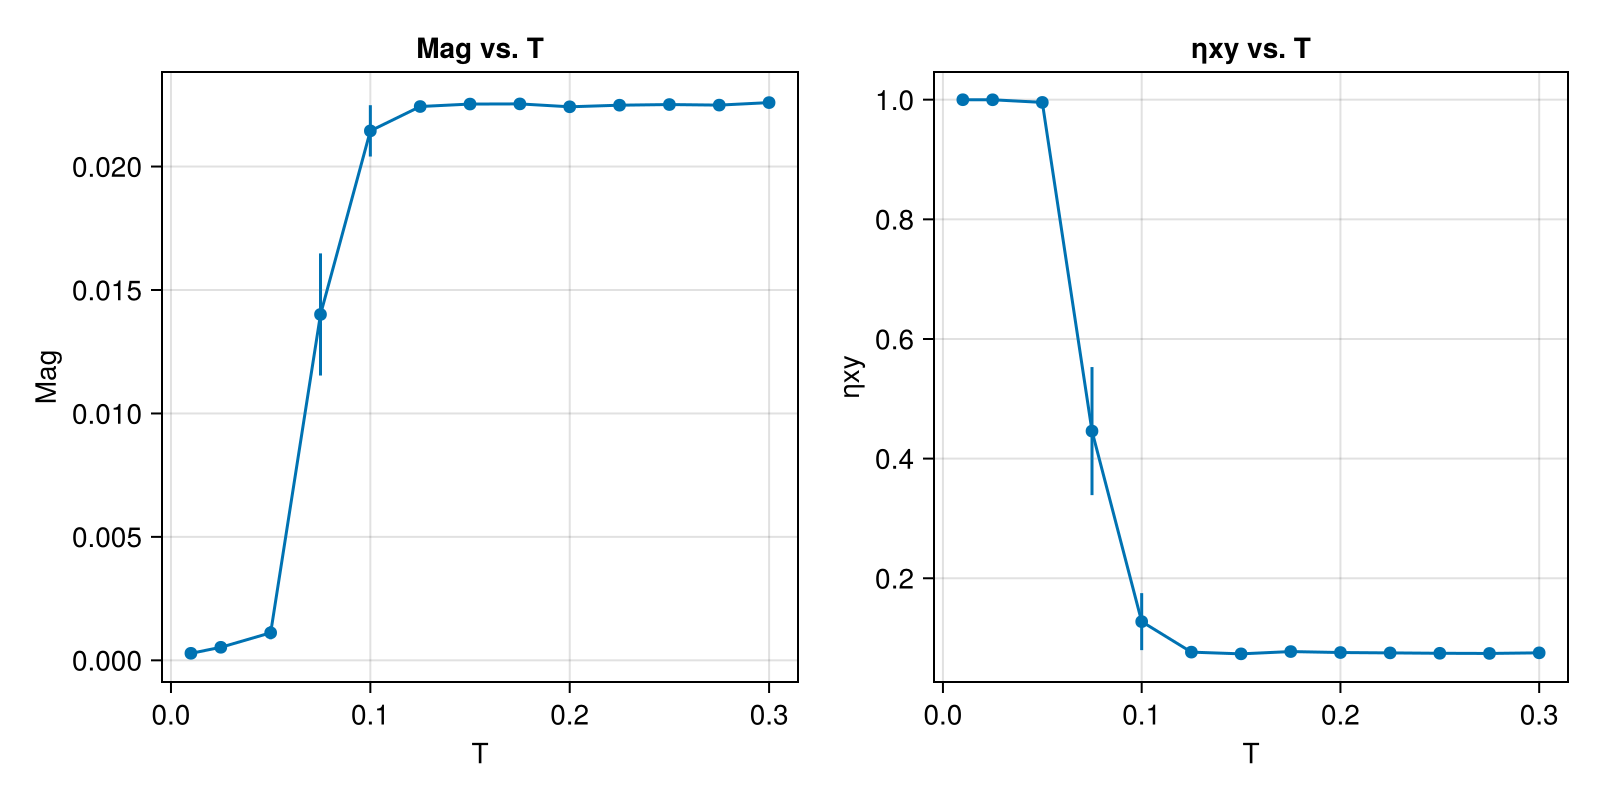

In [35]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Mag vs. T", xlabel="T", ylabel="Mag")
generate_plot!(ax_s, :T, :Mag, center_results; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. T", xlabel="T", ylabel="ηxy")
generate_plot!(ax_η, :T, :ηxy, center_results; line=true)
fig

In [36]:
center_mctimes = get_mctime_data(center_results, :Mag, :ηxy)

13-element Vector{DataFrame}:
 600×2 DataFrame
 Row │ Mag          ηxy      
     │ Float64      Float64  
─────┼───────────────────────
   1 │ 0.000101422  0.999936
   2 │ 0.000103075  0.999936
   3 │ 0.000102785  0.999936
   4 │ 6.90139e-5   0.999936
   5 │ 5.67692e-5   0.999936
   6 │ 5.84821e-5   0.999936
   7 │ 5.33401e-5   0.999936
   8 │ 6.21405e-5   0.999936
  ⋮  │      ⋮          ⋮
 594 │ 0.000214016  0.999947
 595 │ 0.00019393   0.999947
 596 │ 0.000217828  0.999946
 597 │ 0.000215592  0.999946
 598 │ 0.000213152  0.999946
 599 │ 0.000233348  0.999946
 600 │ 0.000237053  0.999947
             585 rows omitted
 600×2 DataFrame
 Row │ Mag          ηxy      
     │ Float64      Float64  
─────┼───────────────────────
   1 │ 0.000278329  0.999876
   2 │ 0.000291858  0.999876
   3 │ 0.000323262  0.999876
   4 │ 0.00037634   0.999878
   5 │ 0.000480742  0.999877
   6 │ 0.000571824  0.999877
   7 │ 0.000488634  0.999877
   8 │ 0.000621363  0.999875
  ⋮  │      ⋮          ⋮
 594 │ 0.

In [ ]:
spink_corrs = center_results[:spink_corrs]

13-element Vector{Matrix{Measurements.Measurement{Float64}}}:
 [1.19e-7 ± 3.4e-8 2.68e-7 ± 4.0e-8 … 2.12e-7 ± 2.7e-8 2.68e-7 ± 4.0e-8; 1.07e-7 ± 2.0e-8 1.41e-7 ± 1.1e-8 … 2.45e-7 ± 2.8e-8 1.78e-7 ± 2.3e-8; … ; 2.1e-7 ± 2.0e-8 1.5e-7 ± 1.8e-8 … 1.54e-7 ± 2.4e-8 1.51e-7 ± 1.9e-8; 1.07e-7 ± 2.0e-8 1.78e-7 ± 2.3e-8 … 1.27e-7 ± 1.1e-8 1.41e-7 ± 1.1e-8]
 [3.68e-7 ± 9.0e-8 3.88e-7 ± 5.2e-8 … 4.11e-7 ± 5.2e-8 3.88e-7 ± 5.2e-8; 4.48e-7 ± 6.3e-8 3.73e-7 ± 3.4e-8 … 4.32e-7 ± 7.7e-8 3.48e-7 ± 6.0e-8; … ; 4.41e-7 ± 5.2e-8 4.63e-7 ± 4.7e-8 … 3.26e-7 ± 4.0e-8 3.1e-7 ± 2.8e-8; 4.48e-7 ± 6.3e-8 3.48e-7 ± 6.0e-8 … 3.97e-7 ± 5.1e-8 3.73e-7 ± 3.4e-8]
 [2.8e-6 ± 1.7e-6 2.4e-6 ± 1.2e-6 … 1.94e-6 ± 8.6e-7 2.4e-6 ± 1.2e-6; 2.6e-6 ± 1.3e-6 3.0e-6 ± 1.8e-6 … 3.1e-6 ± 1.5e-6 2.7e-6 ± 1.3e-6; … ; 2.9e-6 ± 1.6e-6 3.5e-6 ± 1.9e-6 … 3.3e-6 ± 2.0e-6 3.0e-6 ± 1.6e-6; 2.6e-6 ± 1.3e-6 2.7e-6 ± 1.3e-6 … 2.2e-6 ± 1.1e-6 3.0e-6 ± 1.8e-6]
 [0.000357 ± 6.9e-5 0.000366 ± 7.1e-5 … 0.00039 ± 7.5e-5 0.000366 ± 7.1e-5; 0.00036 ± 

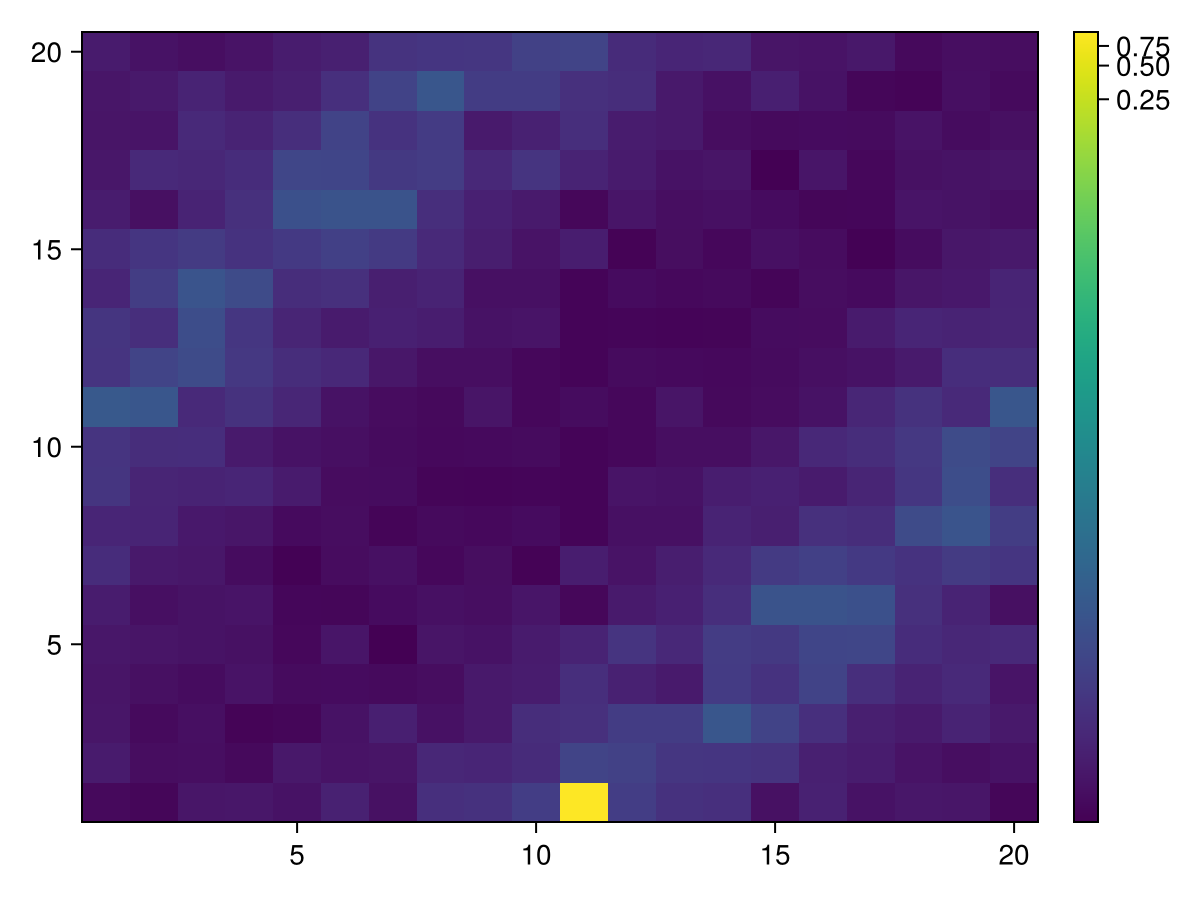

In [44]:
CairoMakie.activate!()
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[1], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

Any[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 5), (14, 7), (12, 6), (10, 5), (8, 4), (6, 3), (4, 2), (2, 1)]


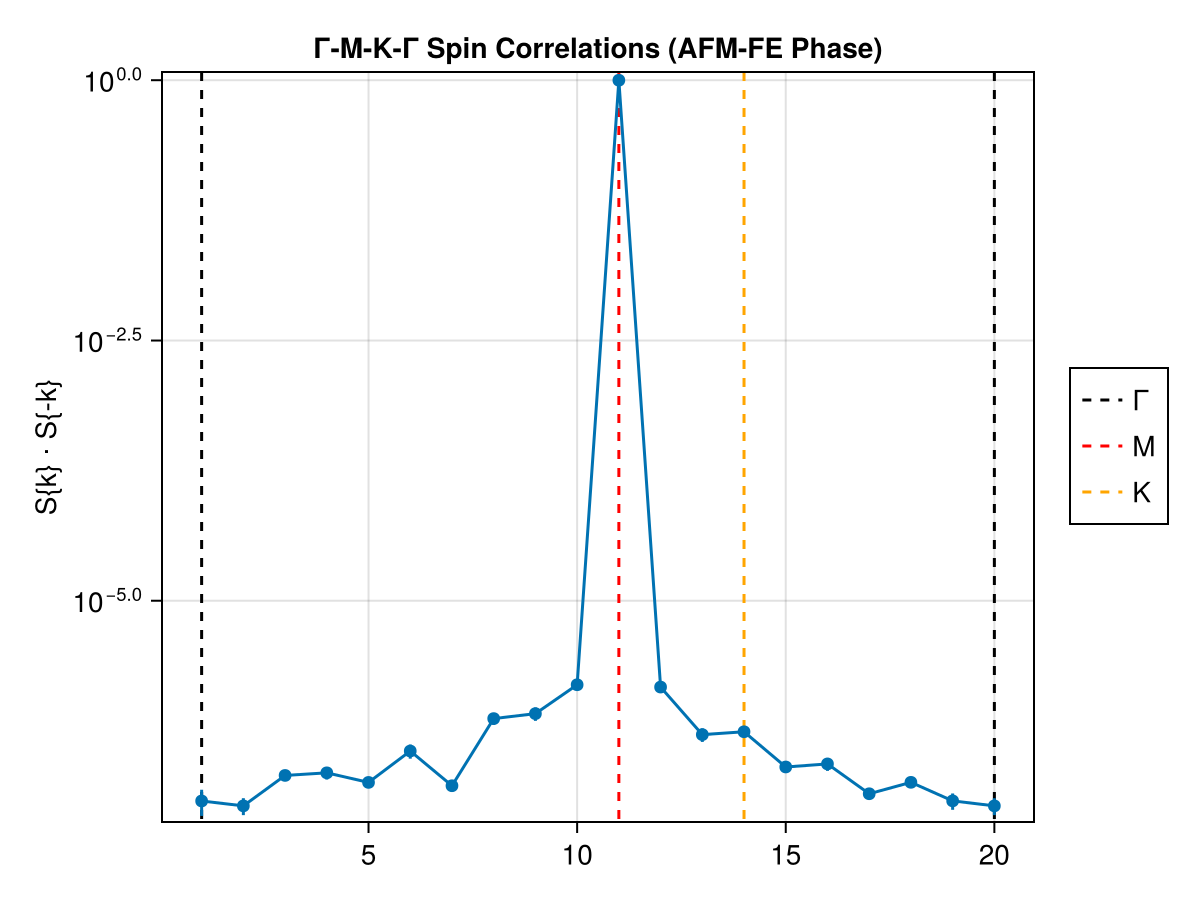

In [51]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[1] < div(Lx, 2) + 1
    pos = pos .+ (1, 0)
    push!(path, pos)
end
M_pos = length(path)
while pos[2] < div(Ly, 3) + 1
    pos = pos .+ (1, 2)
    push!(path, pos)
end
K_pos = length(path)
while pos[2] > 1
    pos = pos .- (2, 1)
    push!(path, pos)
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)

for i in [1]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs)
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.7 * min_corr, 1.2 * max_corr))
Legend(fig[1,2], ax)
fig

## AFM-FE Etas Only

In [13]:
eta_results = JobResult("../jobs", "afm-fe-eta")
separate_etaks!(eta_results.data)

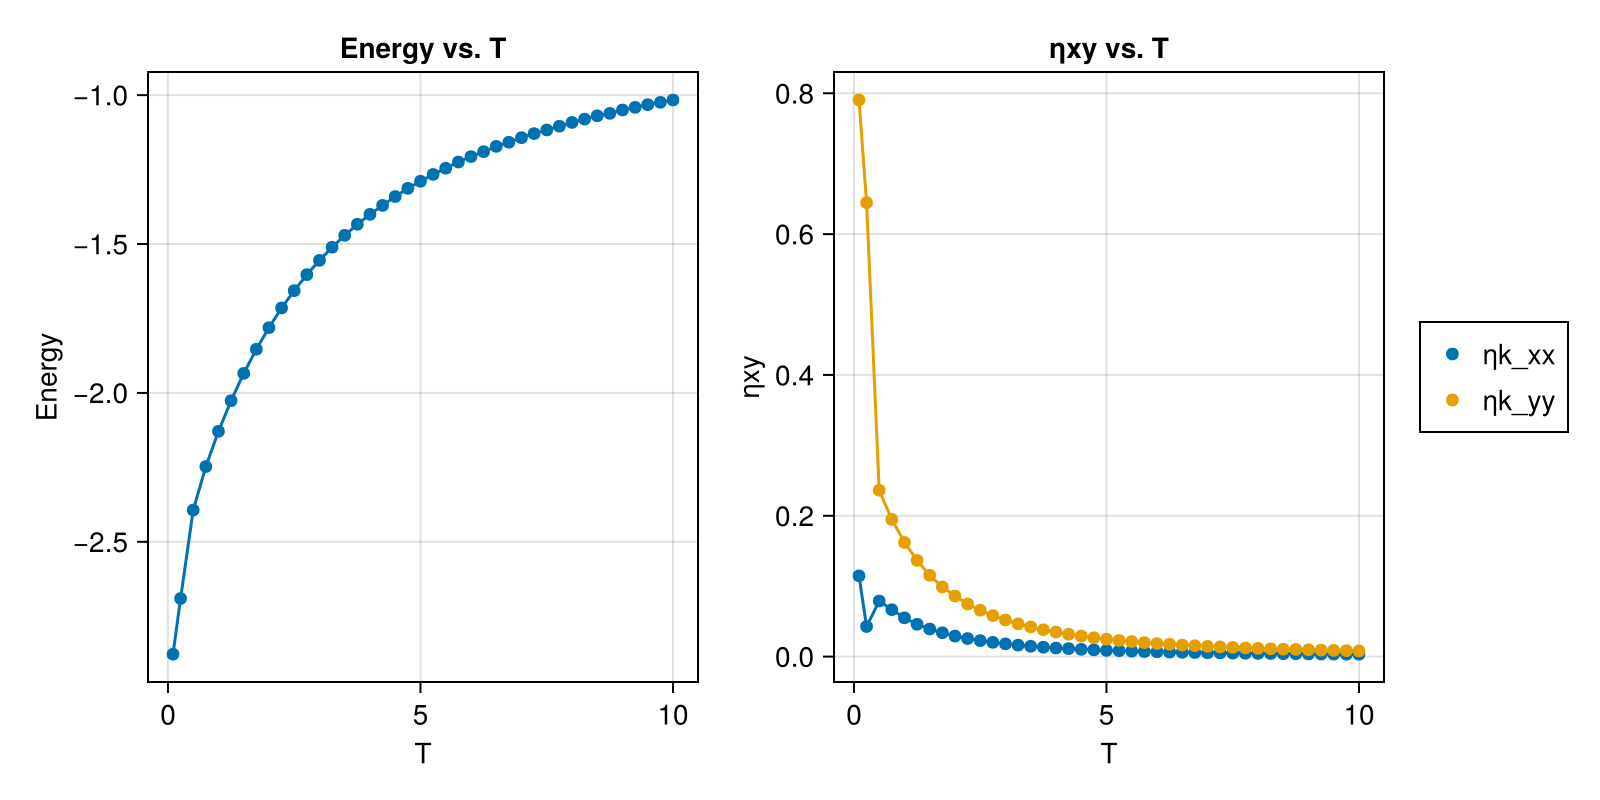

In [14]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Energy vs. T", xlabel="T", ylabel="Energy")
generate_plot!(ax_s, :T, :Energy, eta_results.data; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. T", xlabel="T", ylabel="ηxy")
generate_plot!(ax_η, :T, :ηk_xx_Γ, eta_results.data; line=true, label="ηk_xx")
generate_plot!(ax_η, :T, :ηk_yy_Γ, eta_results.data; line=true, label="ηk_yy")
Legend(fig[1,3], ax_η)
fig

In [15]:
eta_mctimes = get_mctime_data(eta_results, :etak_corrs)
separate_etaks!.(eta_mctimes)

41-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 ⋮
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

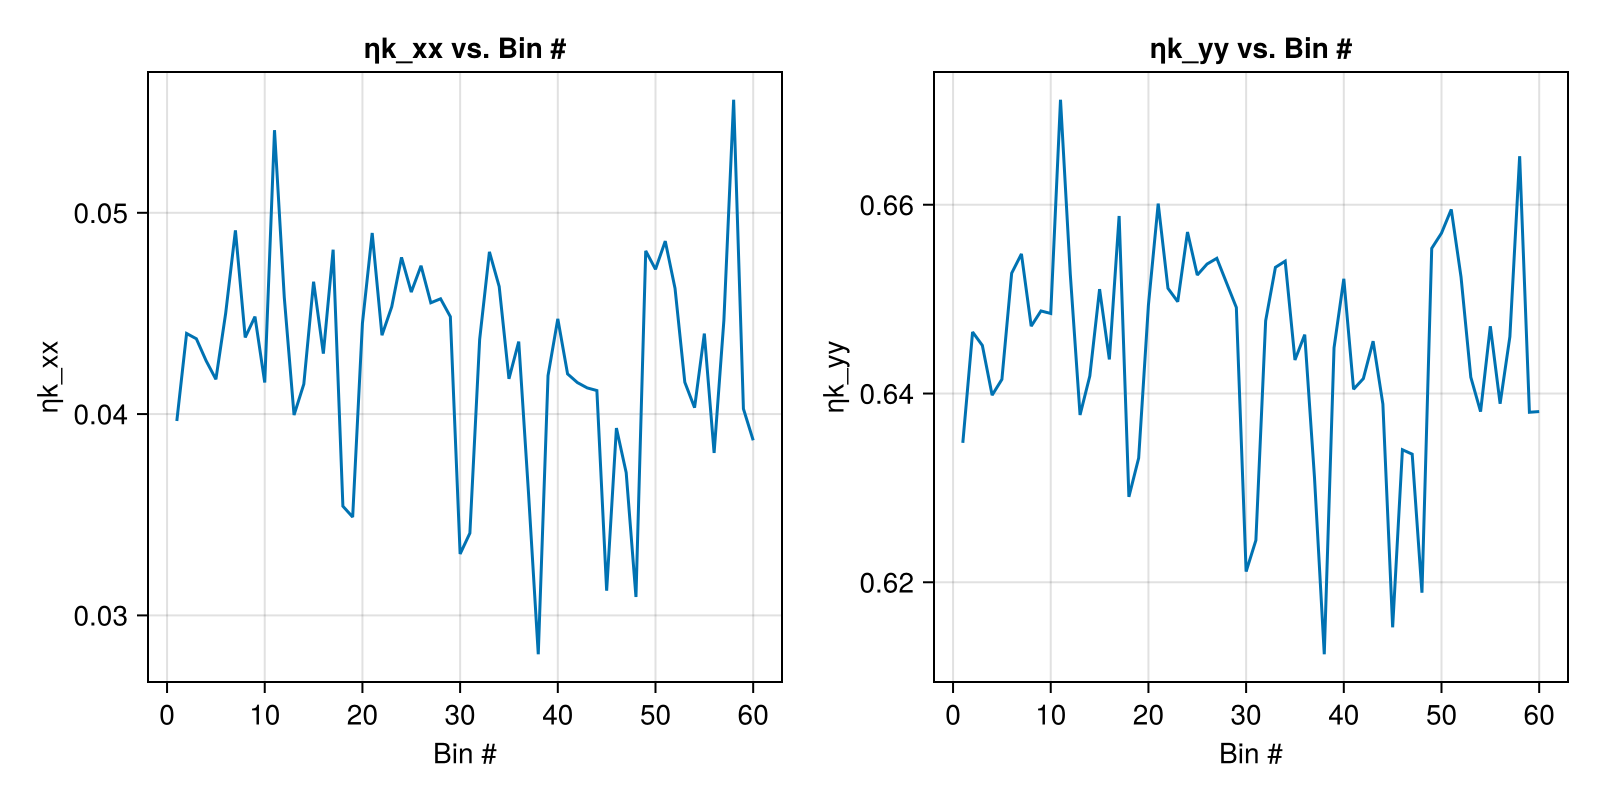

In [16]:
CairoMakie.activate!()
i = 2
k_pos = (1, 1)

var1 = :ηk_xx
var2 = :ηk_yy
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, abs.(getindex.(eta_mctimes[i][:, var1], k_pos...)))
lines!(ax2, abs.(getindex.(eta_mctimes[i][:, var2], k_pos...)))
fig

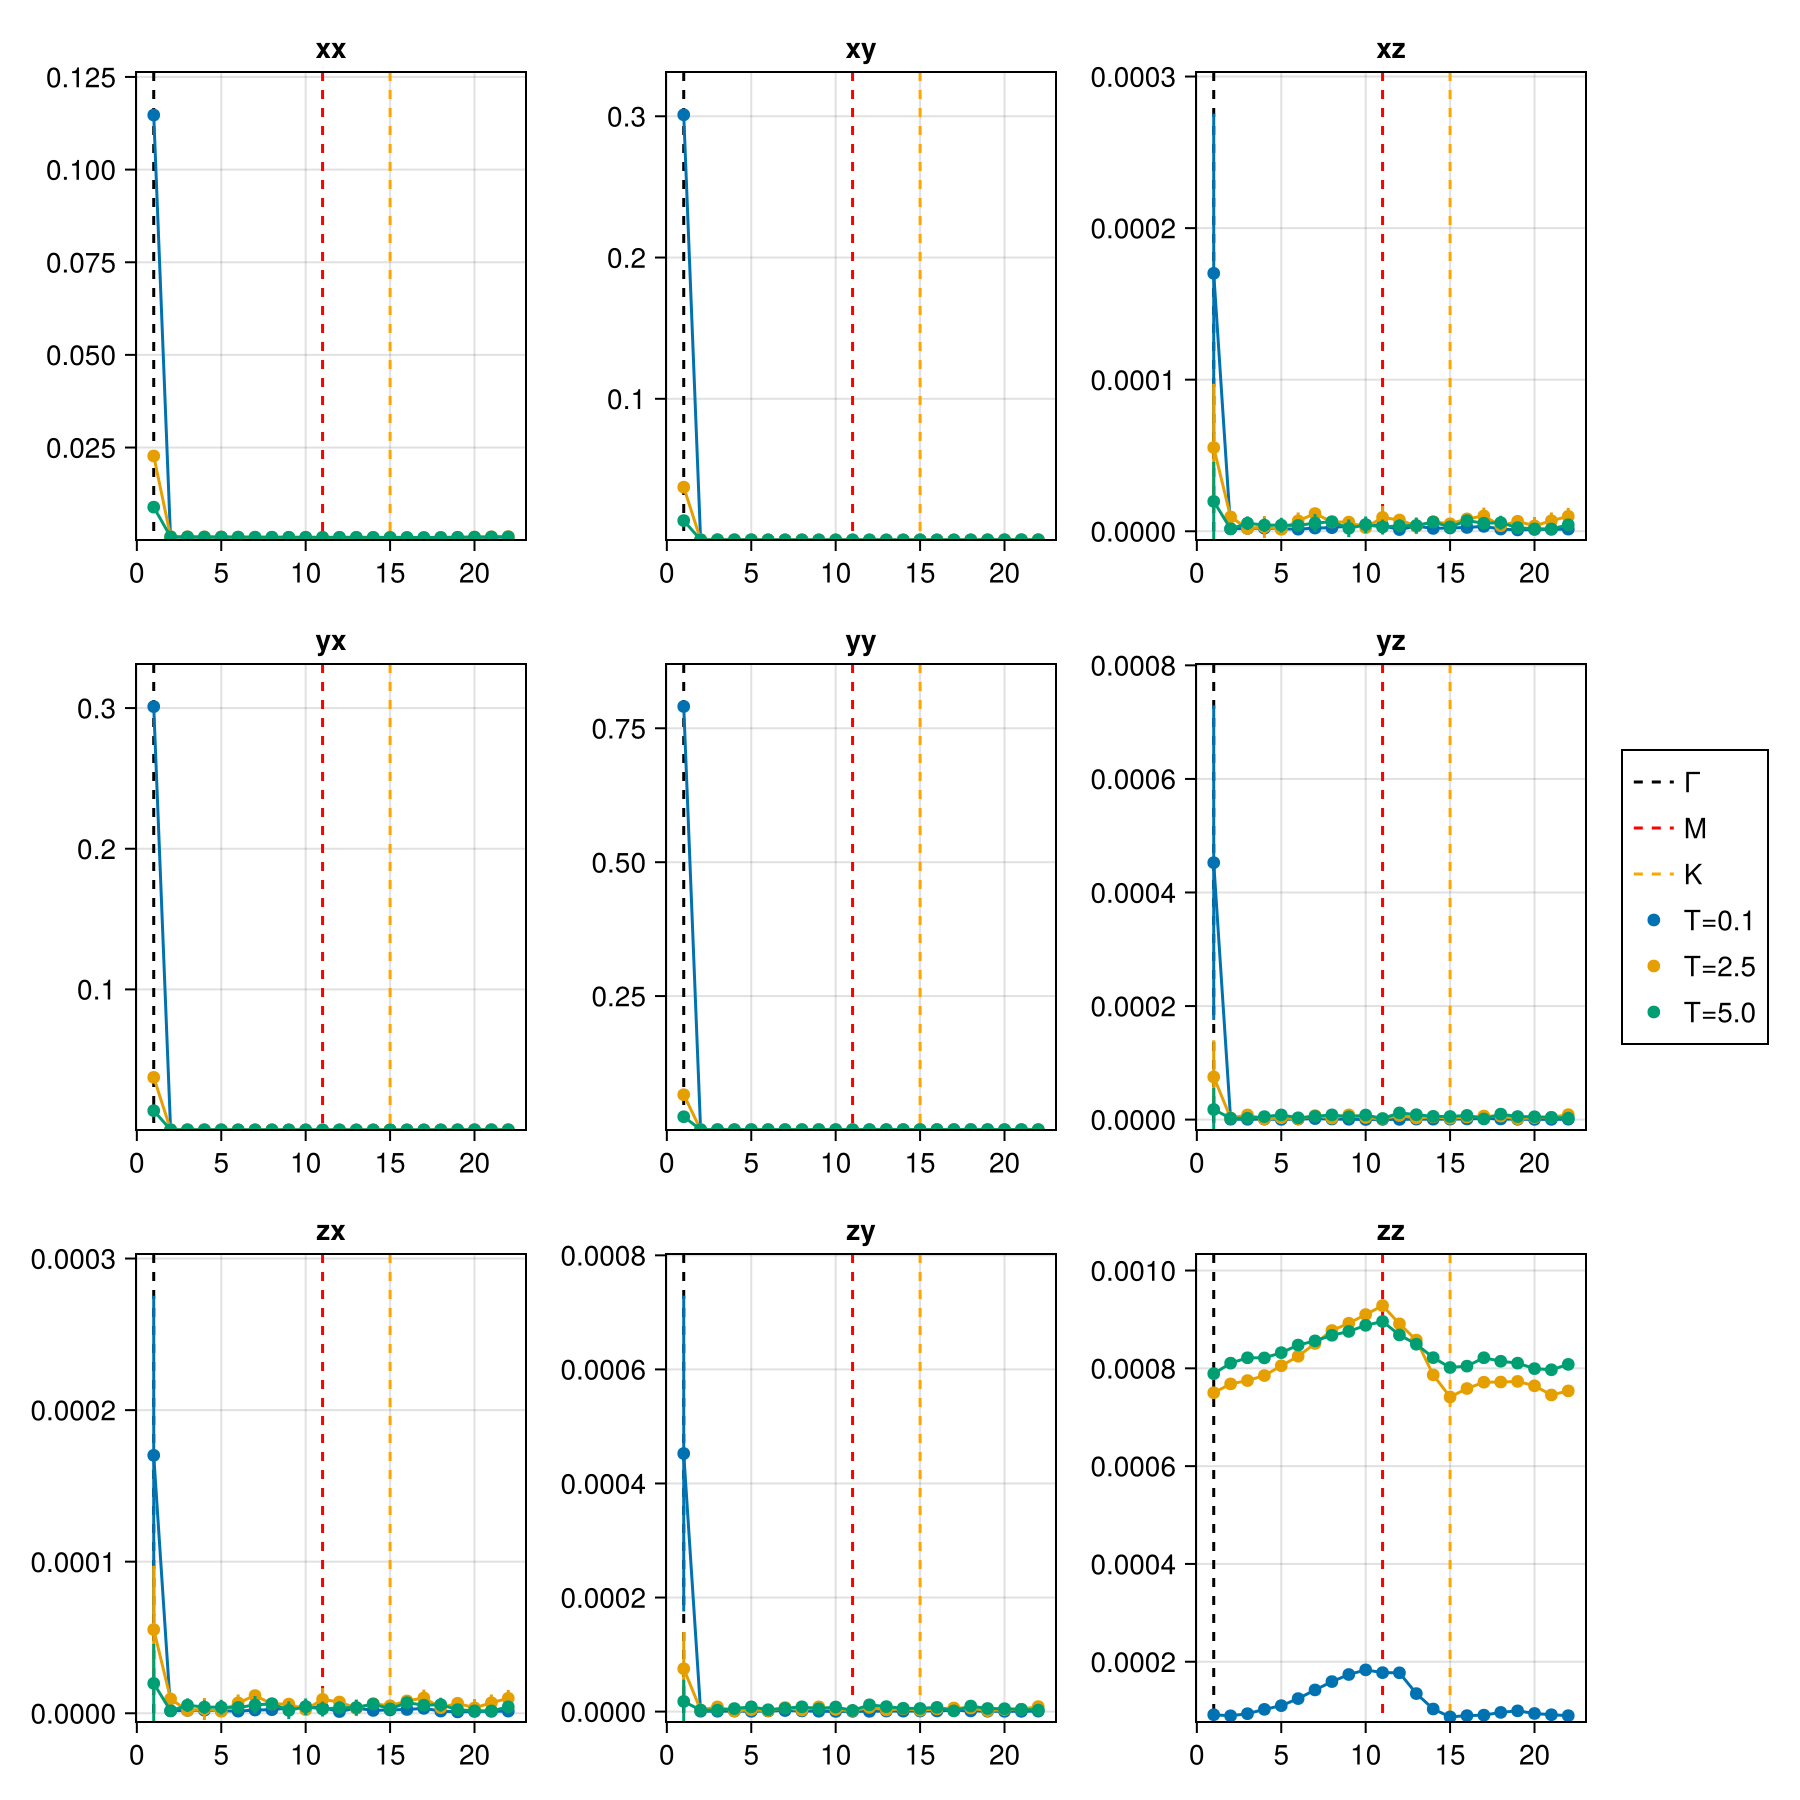

In [17]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Ts = eta_results[:T]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 11, 21]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = eta_results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    all_corrs = [abs(corr_matrices[i][I...]) for I in path for i in is]
    min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
    min_border = 0.9 * min_corr
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = 1.1 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(abs.(corrs), :val)
        corr_errs = getfield.(abs.(corrs), :err)
        scatter!(ax, corr_vals, label="T=$(Ts[i])")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig

## AFM-FE Annealed

In [6]:
results = JobResult("../jobs", "afm-fe-anneal")
nothing

In [7]:
fig = Figure(size=(800, 400))

fig[1,1] = ax_e = Axis(fig, title="M point spin correlation vs. T", xlabel="T", ylabel="sk_M")
generate_plot!(ax_e, :T, :sk_corr_M, results.data; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. T", xlabel="T", ylabel="ηk")
generate_plot!(ax_η, :T, :ηxy, results.data; line=true)

fig

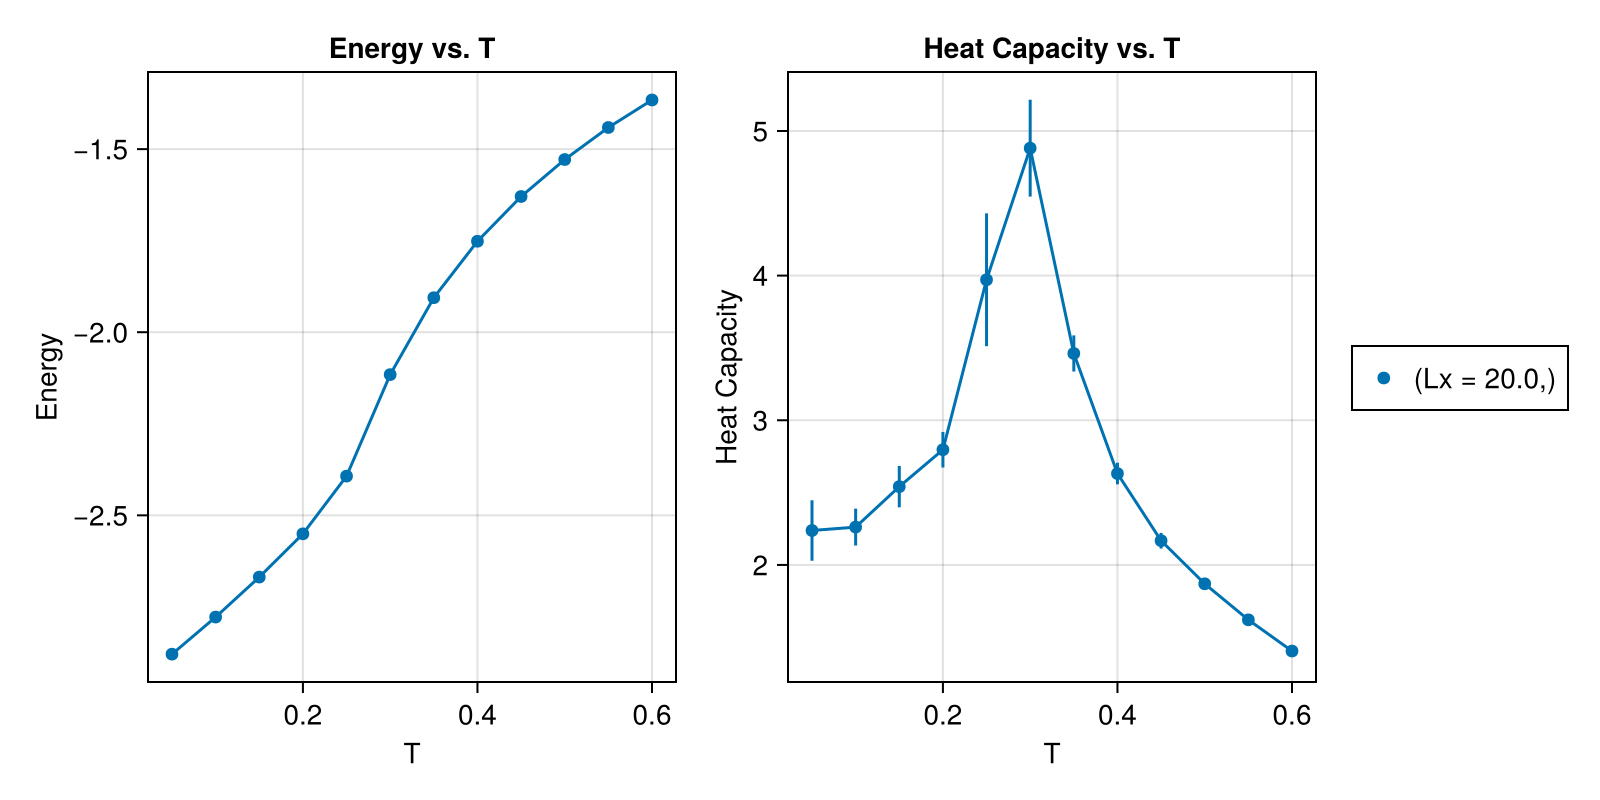

In [8]:
fig = Figure(size=(800, 400))
ax1 = fig[1,1] = Axis(fig, title="Energy vs. T", xlabel="T", ylabel="Energy")
generate_plot!(ax1, :T, :Energy, [:Lx], results.data; line=true)
ax2 = fig[1,2] = Axis(fig, title="Heat Capacity vs. T", xlabel="T", ylabel="Heat Capacity")
generate_plot!(ax2, :T, :HeatCap, [:Lx], results.data; line=true)
Legend(fig[1,3], ax1)
fig

In [9]:
mctimes = get_mctime_data(results, :Mag, :ηxy, :sk_corr_M)
nothing

In [10]:
CairoMakie.activate!()
i = 5
var1 = :ηxy
var2 = :sk_corr_M

fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, abs.(getindex.(mctimes[i][:, var1])))
lines!(ax2, abs.(getindex.(mctimes[i][:, var2])))
fig

In [11]:
CairoMakie.activate!()
path, M_pos, K_pos = gen_path(size(spink_corrs[1])...)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
min_border = 0.9 * min_corr
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_border = 1.1 * max_corr
lines!([(1, max_border), (1, min_border)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, max_border), (M_pos, min_border)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, max_border), (K_pos, min_border)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), max_border), (length(path), min_border)], color=:black, linestyle=:dash)

for i in [1]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs)
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (min_border, max_border))
Legend(fig[1,2], ax)
fig

UndefVarError: UndefVarError: `spink_corrs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [12]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[2] < div(Ly, 2) + 1
    pos = pos .+ (0, 1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
M_pos = length(path)
while pos[2] > div(Ly, 3) + 1
    pos = pos .+ (-2, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
K_pos = length(path)
while pos[2] > 1
    pos = pos .+ (1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)

for i in [1]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs)
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.8 * min_corr, 1.1 * max_corr))
Legend(fig[1,2], ax)
fig

UndefVarError: UndefVarError: `spink_corrs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [13]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[2] > -div(Ly, 2) + 1
    pos = pos .+ (-1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
M_pos = length(path)
while pos[1] < -div(Lx, 3) + 1
    pos = pos .+ (1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
K_pos = length(path)
while pos[2] < 1
    pos = pos .+ (1, 2)
    push!(path, mod1.(pos, (Lx, Ly)))
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)

for i in [1]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs)
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.8 * min_corr, 1.1 * max_corr))
Legend(fig[1,2], ax)
fig

UndefVarError: UndefVarError: `spink_corrs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [14]:
CairoMakie.activate!()

i = 1
Lx = 40
etak_corrs = anneal_results.data[(Lx=Lx,)][:, :etak_corrs]
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)
corr_matrices = eachslice(etak_corrs[i], dims=(1, 2))
max_corrs = maximum(abs.(etak_corrs[i]))
min_corrs = minimum(abs.(etak_corrs[i]))
for x in 1:3
    for y in 1:3
        fig[x, y] = ax = Axis(fig, title="$(labels[x])$(labels[y])")
        corrs = getindex.(corr_matrices, x, y)
        heatmap!(ax, getfield.(abs.(corrs), :val), colorrange=(0, max_corrs.val))
        hidedecorations!(ax)
    end
end

print("Maximum correlation norm: $max_corrs")
fig

UndefVarError: UndefVarError: `anneal_results` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [15]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 12, 23]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = anneal_results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    first_path = [abs(corr_matrices[first(is)][I...]) for I in path]
    min_corr = minimum(getfield.(first_path, :val) - getfield.(first_path, :err))
    min_border = 0.9 * min_corr
    max_corr = maximum(getfield.(first_path, :val) + getfield.(first_path, :err))
    max_border = 1.1 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(abs.(corrs), :val)
        corr_errs = getfield.(abs.(corrs), :err)
        scatter!(ax, corr_vals)
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

fig

UndefVarError: UndefVarError: `anneal_results` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Annealed Bias Field

In [40]:
bias_results = JobResult("../jobs", "afm-fe-bias")

JobResult("../jobs", "afm-fe-bias", 33×44 DataFrame
 Row │ ηk_Γ                               init_T   Magx              ηy        ⋯
     │ Array…                             Float64  Measurem…         Measurem… ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Complex{Measurement{Float64}}[-0…     10.0  -0.0001±0.00015   -0.372±0. ⋯
   2 │ Complex{Measurement{Float64}}[-0…     10.0  -2.5e-5±9.9e-5    -0.461±0.
   3 │ Complex{Measurement{Float64}}[-0…     10.0   0.000188±7.5e-5  -0.483±0.
   4 │ Complex{Measurement{Float64}}[-0…     10.0  -0.000132±9.9e-5  -0.51±0.0
   5 │ Complex{Measurement{Float64}}[0.…     10.0   7.9e-5±9.5e-5    -0.821±0. ⋯
   6 │ Complex{Measurement{Float64}}[-0…     10.0  -3.2e-5±6.4e-5    -0.484±0.
   7 │ Complex{Measurement{Float64}}[-0…     10.0  -6.4e-5±6.4e-5    -0.502±0.
   8 │ Complex{Measurement{Float64}}[0.…     10.0   6.5e-6±8.8e-5    -0.8304±0
  ⋮  │                 ⋮                     ⋮            ⋮          

In [41]:
bias_results[[:_ll_sweep_time, :_ll_measure_time]]

33×2 DataFrame
 Row │ _ll_sweep_time      _ll_measure_time 
     │ Measurement…        Measurement…     
─────┼──────────────────────────────────────
   1 │ 0.000434097±7.6e-8  0.0001727±7.5e-6
   2 │ 0.00043379±1.9e-7   0.0001737±6.7e-6
   3 │ 0.00043497±3.8e-7   0.0001747±6.1e-6
   4 │ 0.00043426±5.4e-7   0.0001767±6.3e-6
   5 │ 0.00043415±1.2e-7   0.0001722±7.6e-6
   6 │ 0.0004351±3.9e-7    0.0001749±6.7e-6
   7 │ 0.00043466±7.0e-7   0.0001762±6.7e-6
   8 │ 0.000457±5.6e-6     0.0001768±6.7e-6
  ⋮  │         ⋮                  ⋮
  27 │ 0.00043729±1.7e-7   0.0001683±2.5e-6
  28 │ 0.0004402±1.1e-6    0.0001668±2.1e-6
  29 │ 0.00043861±7.2e-7   0.0001683±2.0e-6
  30 │ 0.00043863±2.3e-7   0.0001641±2.2e-6
  31 │ 0.00043794±1.1e-7   0.0001686±2.3e-6
  32 │ 0.00043883±3.3e-7   0.0001654±2.2e-6
  33 │ 0.00046±5.3e-6      0.0001655±1.3e-6
                             18 rows omitted

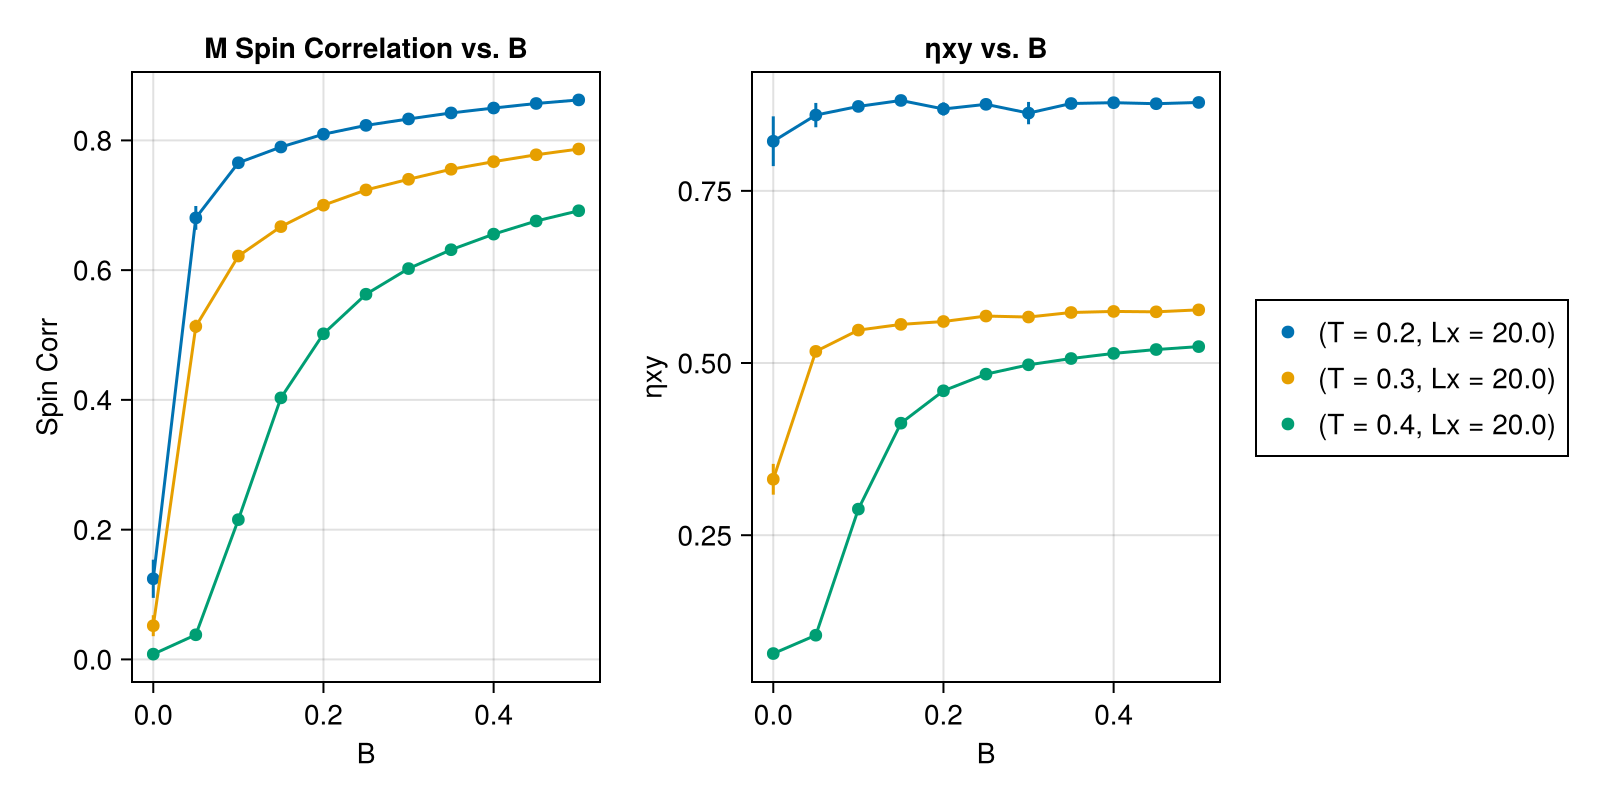

In [42]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
ax1 = fig[1,1] = Axis(fig, title="M Spin Correlation vs. B", xlabel="B", ylabel="Spin Corr")
# scatter!(ax1, bias_results[:B], M_points)
# lines!(ax1, bias_results[:B], M_points)
generate_plot!(ax1, :B, :sk_corr_M, [:T, :Lx], bias_results.data; line=true)
fig[1,2] = ax2 = Axis(fig, title="ηxy vs. B", xlabel="B", ylabel="ηxy")
generate_plot!(ax2, :B, :ηxy, [:T, :Lx], bias_results.data; line=true)
Legend(fig[1,3], ax2)
fig

In [53]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
ax1 = fig[1,1] = Axis(fig, title="Q vs. B", xlabel="B", ylabel="Q")
generate_plot!(ax1, :B, :Q, [:T], bias_results.data; line=true)
fig[1,2] = ax2 = Axis(fig, title="Q2 vs. B", xlabel="B", ylabel="Q2")
generate_plot!(ax2, :B, :Q2, [:T], bias_results.data; line=true)
Legend(fig[1,3], ax2)
fig

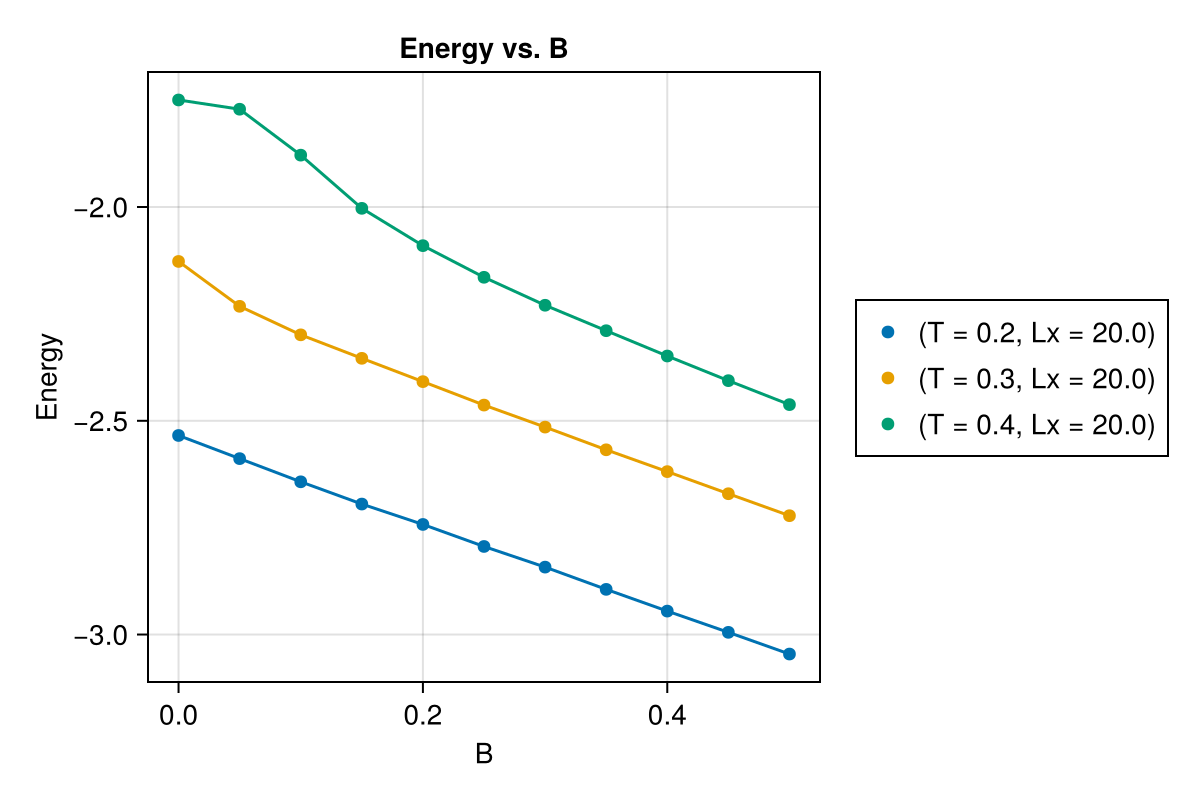

In [43]:
fig = Figure(size=(600, 400))
ax1 = fig[1,1] = Axis(fig, title="Energy vs. B", xlabel="B", ylabel="Energy")
# scatter!(ax1, bias_results[:B], M_points)
# lines!(ax1, bias_results[:B], M_points)
generate_plot!(ax1, :B, :Energy, [:T, :Lx], bias_results.data; line=true)
Legend(fig[1,2], ax1)
fig

In [44]:
fig = Figure()
ax = fig[1,1] = Axis(fig)

Axis with 0 plots:


In [45]:
bias_mctimes = get_mctime_data(bias_results, :sk_corr_M, :ηxy)
nothing

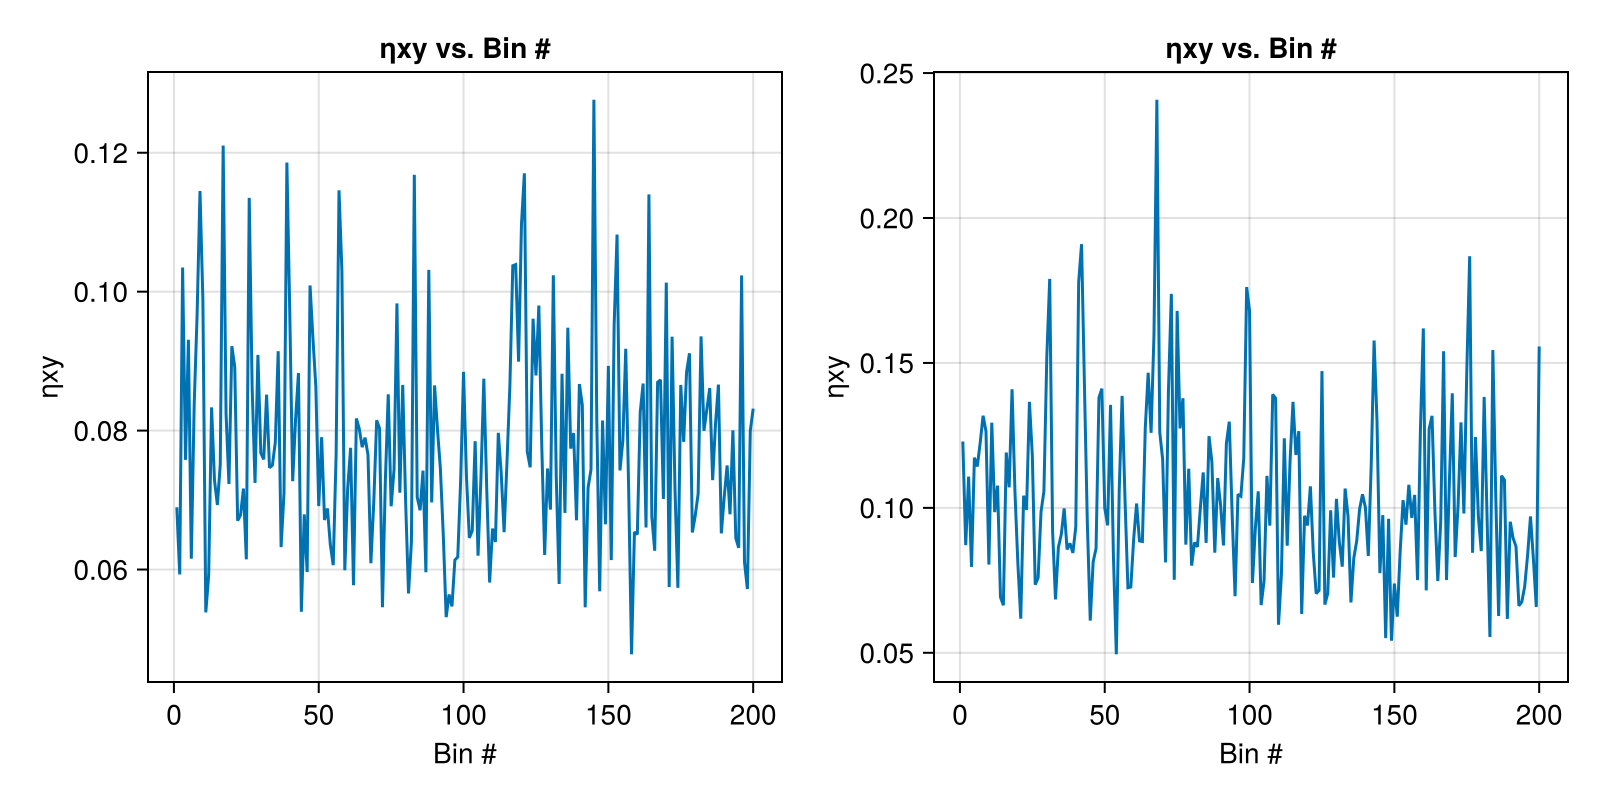

In [46]:
CairoMakie.activate!()
i = 23
k_pos = (1, 1)

var1 = :ηxy
var2 = :ηxy
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, abs.(first.(bias_mctimes[i][:, var1])))
lines!(ax2, abs.(first.(bias_mctimes[i+1][:, var2])))
fig

In [47]:
CairoMakie.activate!()
spink_corrs = bias_results[:spink_corrs]
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[1], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

ArgumentError: ArgumentError: column name :spink_corrs not found in the data frame

In [48]:
CairoMakie.activate!()
spink_corrs = bias_results[:spink_corrs]
is = [1, 5, 9]

spink_corrs = bias_results[:spink_corrs]
Bs = bias_results[:B]
path, M_pos, K_pos = gen_path(size(spink_corrs[1])...)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

all_corrs = [spink_corrs[i][I...] for I in path for i in is]
min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
min_border = 0.9 * min_corr
max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
max_border = 1.1 * max_corr
lines!([(1, max_border), (1, min_border)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, max_border), (M_pos, min_border)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, max_border), (K_pos, min_border)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), max_border), (length(path), min_border)], color=:black, linestyle=:dash)

for i in is
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs, label="B=$(Bs[i])")
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (min_border, max_border))
Legend(fig[1,2], ax)
fig

ArgumentError: ArgumentError: column name :spink_corrs not found in the data frame

In [49]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[2] < div(Ly, 2) + 1
    pos = pos .+ (0, 1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
M_pos = length(path)
while pos[2] > div(Ly, 3) + 1
    pos = pos .+ (-2, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
K_pos = length(path)
while pos[2] > 1
    pos = pos .+ (1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

all_corrs = [spink_corrs[i][I...] for I in path for i in is]
min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
min_border = 0.9 * min_corr
max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
max_border = 1.1 * max_corr
lines!([(1, max_border), (1, min_border)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, max_border), (M_pos, min_border)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, max_border), (K_pos, min_border)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), max_border), (length(path), min_border)], color=:black, linestyle=:dash)

for i in is
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs, label="B=$(Bs[i])")
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.8 * min_corr, 1.1 * max_corr))
Legend(fig[1,2], ax)
fig

UndefVarError: UndefVarError: `spink_corrs` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [50]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[2] > -div(Ly, 2) + 1
    pos = pos .+ (-1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
M_pos = length(path)
while pos[1] < -div(Lx, 3) + 1
    pos = pos .+ (1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
K_pos = length(path)
while pos[2] < 1
    pos = pos .+ (1, 2)
    push!(path, mod1.(pos, (Lx, Ly)))
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)

for i in [1]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs)
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.8 * min_corr, 1.1 * max_corr))
Legend(fig[1,2], ax)
fig

UndefVarError: UndefVarError: `spink_corrs` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [51]:
CairoMakie.activate!()

i = 7
Lx = 40
etak_corrs = bias_results[:etak_corrs]
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)
corr_matrices = eachslice(etak_corrs[i], dims=(1, 2))
max_corrs = maximum(abs.(etak_corrs[i]))
min_corrs = minimum(abs.(etak_corrs[i]))
for x in 1:3
    for y in 1:3
        fig[x, y] = ax = Axis(fig, title="$(labels[x])$(labels[y])")
        corrs = getindex.(corr_matrices, x, y)
        heatmap!(ax, getfield.(abs.(corrs), :val), colorrange=(0, max_corrs.val))
        hidedecorations!(ax)
    end
end

print("Maximum correlation norm: $max_corrs")
fig

ArgumentError: ArgumentError: column name :etak_corrs not found in the data frame

In [52]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Bs = bias_results[:B]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 5, 9]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = bias_results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    all_corrs = [abs(corr_matrices[i][I...]) for I in path for i in is]
    min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
    min_border = 0.9 * min_corr
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = 1.1 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(abs.(corrs), :val)
        corr_errs = getfield.(abs.(corrs), :err)
        scatter!(ax, corr_vals, label="B=$(Bs[i])")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig

ArgumentError: ArgumentError: column name "ηk_xx" not found in the data frame; existing most similar names are: "ηk_M" and "ηk_Γ"